<h1 align=center><font size = 5>TASK-3</font></h1>
<h1 align=center><font size = 3>MIDAS Summer Internship 2021</font></h1>
<h1 align=center><font size = 3>Research Track: NLP</font></h1>

<h2 align=left><font size = 2>Varun Khurana<br> CSE, Indraprastha Institute of Information Technology, Delhi</font></h2>

[varun19124@iiitd.ac.in](mailto:varun19124@iiitd.ac.in)

***
***Brief Description of Task and Dataset***
<br>
/* Description */

***Brief Description of Approach/Flow of work***
<br>
/* Description */

Let us import the required libraries...

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [105]:
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

print(tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
))
tf.config.list_physical_devices('GPU')

True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Let us fetch the dataset...

In [2]:
df = pd.read_csv("flipkart_com-ecommerce_sample.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


Checking for null values...

In [3]:
df.isnull().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 78
discounted_price             78
image                         3
is_FK_Advantage_product       0
description                   2
product_rating                0
overall_rating                0
brand                      5864
product_specifications       14
dtype: int64

We will use product description as the main feature to predict the product category. We will drop the rows having null values in description.

In [4]:
df = df.dropna(how='any', subset=['description'])

In [5]:
df2 = df[['description', 'product_category_tree']]
df2.head()

,description,product_category_tree
0,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""Furniture >> Living Room Furniture >> Sofa B..."
2,Key Features of AW Bellies Sandals Wedges Heel...,"[""Footwear >> Women's Footwear >> Ballerinas >..."
3,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl..."
4,Specifications of Sicons All Purpose Arnica Do...,"[""Pet Supplies >> Grooming >> Skin & Coat Care..."


From the product category tree we will find the primary product category i.e. the root of the product category tree.

In [6]:
def filter_primary_category(tree):
    tree_list = tree.split('>>')
    category = tree_list[0]
    return category


In [7]:
product_df = df2.loc[:]
product_df['category'] = df2['product_category_tree'].apply(filter_primary_category)

In [8]:
product_df.head()

,description,product_category_tree,category
0,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl...","[""Clothing"
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""Furniture >> Living Room Furniture >> Sofa B...","[""Furniture"
2,Key Features of AW Bellies Sandals Wedges Heel...,"[""Footwear >> Women's Footwear >> Ballerinas >...","[""Footwear"
3,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing >> Women's Clothing >> Lingerie, Sl...","[""Clothing"
4,Specifications of Sicons All Purpose Arnica Do...,"[""Pet Supplies >> Grooming >> Skin & Coat Care...","[""Pet Supplies"


In [9]:
# Dropping redundant column "product_category_tree"
product_df = product_df[['description', 'category']]
product_df.head()

,description,category
0,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing"
1,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""Furniture"
2,Key Features of AW Bellies Sandals Wedges Heel...,"[""Footwear"
3,Key Features of Alisha Solid Women's Cycling S...,"[""Clothing"
4,Specifications of Sicons All Purpose Arnica Do...,"[""Pet Supplies"


We wil now further clean the data by:
1. Removing punctuation
2. Converting text data to lower case
3. Stripping leading and trailing whitespaces
4. Removing stopwords

#### Removing Punctuation
This will remove special punctuation characters that are redundant in our dataset.

In [10]:
import string

def remove_punctuation_marks(text):
    text_clean = ""
    for i in text:
        if i not in string.punctuation:
            text_clean += i
    return text_clean


In [11]:
product_df['category'] = product_df['category'].apply(remove_punctuation_marks)
product_df['description'] = product_df['description'].apply(remove_punctuation_marks)

# For the sake of uniformity, we will convert 'category' column entries to lower case
product_df['category'] = product_df['category'].str.lower()

# Removing trailing and leading whitespaces, if any
product_df['category'] = product_df['category'].str.strip()

product_df.head()

,description,category
0,Key Features of Alisha Solid Womens Cycling Sh...,clothing
1,FabHomeDecor Fabric Double Sofa Bed Finish Col...,furniture
2,Key Features of AW Bellies Sandals Wedges Heel...,footwear
3,Key Features of Alisha Solid Womens Cycling Sh...,clothing
4,Specifications of Sicons All Purpose Arnica Do...,pet supplies


#### Removing Stopwords
This will ensure redundant words are removed and we are left with only meaningful words which give some information.
For this we will use the corpus of English language stopwords from the Natural Language Toolkit (NLTK).

In [12]:
nltk.download('stopwords')
from nltk.corpus import stopwords
# stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\varun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def remove_stopwords(text):
    word_list = []
    for i in text.split():
        if i.lower() not in stopwords.words('english'):
            word_list.append(i.lower())
    text_clean = " ".join(word_list)
    return text_clean


In [14]:
product_df['description'] = product_df['description'].apply(remove_stopwords)
product_df.head()

,description,category
0,key features alisha solid womens cycling short...,clothing
1,fabhomedecor fabric double sofa bed finish col...,furniture
2,key features aw bellies sandals wedges heel ca...,footwear
3,key features alisha solid womens cycling short...,clothing
4,specifications sicons purpose arnica dog shamp...,pet supplies


In [15]:
product_df.nunique()

description    17503
category         265
dtype: int64

So, as can be seen above, there are hundreds of product categories. But a large percentage of them are very infrequent and occur rarely.
<br>
<br>
Let us identify the most frequent product categories.

In [16]:
category_count = product_df['category'].value_counts()
print(category_count, "\n\n")

frequent_category_list = []

for i in zip(category_count.values, category_count.index):
    if i[0] >= 10:
        frequent_category_list.append(i[1])
        
print("FREQUENT CATEGORIES:\n", frequent_category_list, "\n\nlength =", len(frequent_category_list))

clothing                                         6197
jewellery                                        3531
footwear                                         1227
mobiles  accessories                             1099
automotive                                       1012
                                                 ... 
urban girl foundation brush pack of 12              1
kraft seeds rosemary herb pack of 5 seed 75 p       1
newgen tech eohs3303 179 wired headset white        1
shonaya printed bhagalpuri art silk sari            1
speedwav 216456 manual rear view mirror right       1
Name: category, Length: 265, dtype: int64 


FREQUENT CATEGORIES:
 ['clothing', 'jewellery', 'footwear', 'mobiles  accessories', 'automotive', 'home decor  festive needs', 'beauty and personal care', 'home furnishing', 'kitchen  dining', 'computers', 'watches', 'baby care', 'tools  hardware', 'toys  school supplies', 'pens  stationery', 'bags wallets  belts', 'furniture', 'sports  fitness', 'cameras  ac

There are several product categories that occur with very little frequency in our data. This can cause class imbalance problem. So, let us remove the entries with less frequent product categories.

In [17]:
product_df_clean = product_df[(product_df['category']).isin(frequent_category_list)]

product_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19666 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  19666 non-null  object
 1   category     19666 non-null  object
dtypes: object(2)
memory usage: 460.9+ KB



Let us plot a **Word Cloud** to visualise the common product categories.

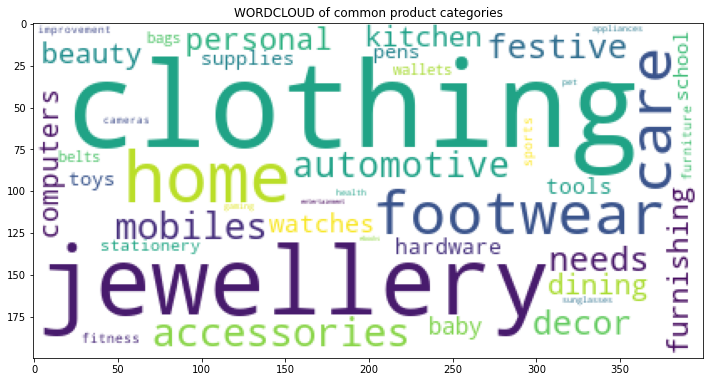

In [18]:
from wordcloud import WordCloud

category_count = product_df_clean['category'].value_counts()

category_string = ""
for i in range(len(frequent_category_list)):
    category_string += (frequent_category_list[i] + " " )*(category_count.values[i])

plt.figure(figsize=(12, 8))
plt.title("WORDCLOUD of common product categories")
plt.imshow(WordCloud(background_color='white', collocations=False).generate(category_string))

We can also use a **Bar Graph** to visualise the distribution of common product categories.

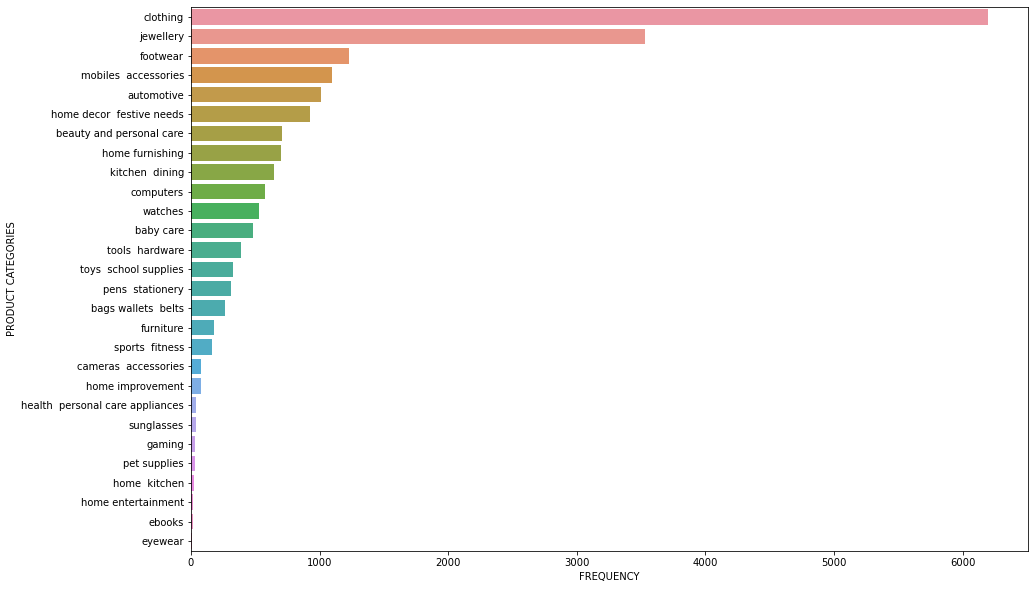

In [19]:
plt.figure(figsize=(15, 10))
plt.ylabel("PRODUCT CATEGORIES")
plt.xlabel("FREQUENCY")
bar_graph = sns.barplot(y=category_count.index, x=category_count.values)
plt.show()

Now let us replace each product category (in text form) with a corresponding numerical label i.e. each category is mapped to a unique integer. This will help our model to perform classification on the categorical attribute.

In [20]:
def convert_category(category_text):
    idx = frequent_category_list.index(category_text)
    return idx

product_df = product_df_clean
product_df['# category'] = product_df_clean['category'].apply(convert_category)

product_df = product_df[['description', '# category']]

In [33]:
product_df.head()

,description,category,#category
0,key features alisha solid womens cycling short...,clothing,0
1,fabhomedecor fabric double sofa bed finish col...,furniture,16
2,key features aw bellies sandals wedges heel ca...,footwear,2
3,key features alisha solid womens cycling short...,clothing,0
4,specifications sicons purpose arnica dog shamp...,pet supplies,23


Now, that we are done with cleaning the text data, let us move ahead to extract features from the given text data.

#### Perform Count Vectorisation followed by Term-Frequency and Inverse Document Frequency (TF-IDF)

- Here, our goal is to effectively extract features from the text product description so that a product category can be predicted.
- We first obtain the sentence vectors by applying count vectorisation.
- Thereafter, we compute the TF-IDF to get obtain weighted vectors such that more weight is given to particular words that form a distinguishing feature for a category.

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vectorizer = CountVectorizer()
product_count = count_vectorizer.fit_transform(product_df['description'])

tfidf_transformer = TfidfTransformer()
product_tfidf = tfidf_transformer.fit_transform(product_count)

print(product_tfidf.shape)

(19666, 31954)


In [23]:
X = pd.DataFrame(product_tfidf.toarray())
X.shape

(19666, 31954)

In [24]:
y = product_df['# category']
y.shape

(19666,)

Now, all pre-processing steps are complete and we are all set to build our model for text classification.

We will first split the data into training and testing sets, keeping the test set ratio = 30%.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Let's use the **Naive Bayes Classifier** for our model.

In [48]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

Now let's test our classification model by predicting product categories for the test set description. 

In [27]:
y_hat = model.predict(X_test)
y_hat.shape

(5900,)

Let's visualise the accuracy of our model using a **confusion matrix** as follows:

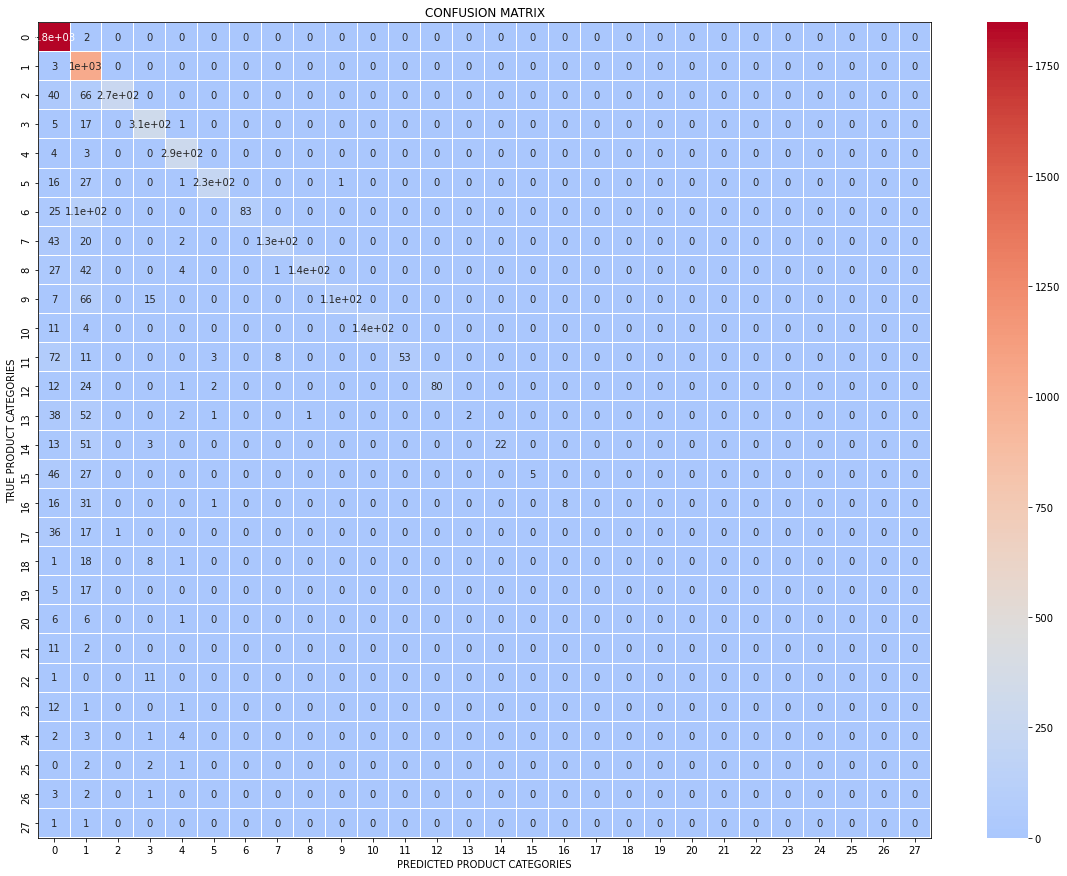

In [28]:
c_matrix = confusion_matrix(y_test, y_hat)

# Converting to dataframe
df_cm = pd.DataFrame(c_matrix)
df_cm.index.name = 'TRUE PRODUCT CATEGORIES'
df_cm.columns.name = 'PREDICTED PRODUCT CATEGORIES'
cm_center = 0.25 * (df_cm.values.max() - df_cm.values.min())

plt.figure(figsize=(20,15))
plt.title("CONFUSION MATRIX")
cm_plot = sns.heatmap(df_cm, annot=True, linewidths=.005, cmap= "coolwarm", center=cm_center)

for _, spine in cm_plot.spines.items():
    spine.set_visible(True)

plt.show()

Below are the perfomance metrics of our classification model.

In [43]:
print(classification_report(y_test, y_hat, target_names=frequent_category_list))

                                  precision    recall  f1-score   support

                        clothing       0.80      1.00      0.89      1850
                       jewellery       0.62      1.00      0.77      1030
                        footwear       1.00      0.72      0.83       372
            mobiles  accessories       0.88      0.93      0.91       335
                      automotive       0.94      0.98      0.96       298
       home decor  festive needs       0.97      0.84      0.90       273
        beauty and personal care       1.00      0.38      0.55       218
                 home furnishing       0.94      0.67      0.78       198
                 kitchen  dining       0.99      0.65      0.78       209
                       computers       0.99      0.55      0.70       194
                         watches       1.00      0.91      0.95       159
                       baby care       1.00      0.36      0.53       147
                 tools  hardware     

C:\Users\varun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
nb_accuracy = accuracy_score(y_test, y_hat)
print("The accuracy of Naive Bayes Classifier model = %.2f" %(nb_accuracy*100), "%")

The accuracy of Naive Bayes Classifier model = 80.39 %


Let's try using other classification algorithms to check if we can achieve higher accuracy.

**Logistic Regression**
<br>
This will give the probability of a product belonging to each category. The category with the highest probability will get selected as the predicted category.

In [94]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=0.5)
lr_model.fit(X_train, y_train)

LogisticRegression(C=0.5)

In [95]:
y_hat = lr_model.predict(X_test)
y_hat_probability = lr_model.predict_proba(X_test)

In [96]:
print(classification_report(y_test, y_hat, target_names=frequent_category_list))

                                  precision    recall  f1-score   support

                        clothing       0.93      1.00      0.96      1850
                       jewellery       0.97      1.00      0.98      1030
                        footwear       0.95      0.98      0.96       372
            mobiles  accessories       0.91      0.96      0.93       335
                      automotive       0.95      0.99      0.97       298
       home decor  festive needs       0.88      0.96      0.92       273
        beauty and personal care       0.97      0.94      0.95       218
                 home furnishing       0.91      0.95      0.93       198
                 kitchen  dining       0.93      0.96      0.94       209
                       computers       0.95      0.91      0.93       194
                         watches       1.00      0.98      0.99       159
                       baby care       0.95      0.67      0.79       147
                 tools  hardware     

C:\Users\varun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
lr_accuracy = accuracy_score(y_test, y_hat)
print("The accuracy of Logistic Regression model = %.2f" %(lr_accuracy*100), "%")

The accuracy of Logistic Regression model = 93.92 %


**Support Vector Machine**

In [98]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_hat = svm_model.predict(X_test)

In [99]:
svm_accuracy = accuracy_score(y_test, y_hat)
print("The accuracy of Support Vector Machine model = %.2f" %(svm_accuracy*100), "%")

The accuracy of Support Vector Machine model = 97.85 %


In [100]:
print(classification_report(y_test, y_hat, target_names=frequent_category_list))

                                  precision    recall  f1-score   support

                        clothing       0.99      0.99      0.99      1850
                       jewellery       1.00      1.00      1.00      1030
                        footwear       1.00      1.00      1.00       372
            mobiles  accessories       0.97      0.98      0.98       335
                      automotive       0.98      1.00      0.99       298
       home decor  festive needs       0.97      0.99      0.98       273
        beauty and personal care       0.99      0.99      0.99       218
                 home furnishing       0.95      0.98      0.97       198
                 kitchen  dining       0.94      0.97      0.96       209
                       computers       0.98      0.97      0.98       194
                         watches       0.99      1.00      1.00       159
                       baby care       0.92      0.82      0.86       147
                 tools  hardware     


**Classification Using Neural Network**

In [160]:
# input layer nodes
num_cols = X.shape[1]

# output layer nodes
num_classes = len(frequent_category_list)

# One-hot encoding for target variable y i.e. product category
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)


# defining function to construct neural network
def classify_model():
    # creating model
    model = Sequential()
    model.add(Dense(50, activation='relu', input_shape=(num_cols,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # compiling model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [161]:
nnet_model = classify_model()

history = nnet_model.fit(X_train.values, y_train_cat, validation_data=(X_test.values, y_test_cat), epochs=20, verbose=2)

Epoch 1/20
431/431 - 7s - loss: 0.8796 - accuracy: 0.7758 - val_loss: 0.2313 - val_accuracy: 0.9419
Epoch 2/20
431/431 - 5s - loss: 0.1037 - accuracy: 0.9735 - val_loss: 0.1493 - val_accuracy: 0.9622
Epoch 3/20
431/431 - 4s - loss: 0.0297 - accuracy: 0.9916 - val_loss: 0.1365 - val_accuracy: 0.9668
Epoch 4/20
431/431 - 5s - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.1469 - val_accuracy: 0.9637
Epoch 5/20
431/431 - 5s - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.1348 - val_accuracy: 0.9685
Epoch 6/20
431/431 - 6s - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.1379 - val_accuracy: 0.9669
Epoch 7/20
431/431 - 5s - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.1574 - val_accuracy: 0.9644
Epoch 8/20
431/431 - 4s - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.1483 - val_accuracy: 0.9668
Epoch 9/20
431/431 - 4s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.1496 - val_accuracy: 0.9673
Epoch 10/20
431/431 - 4s - loss: 0.0024 - accuracy: 0.9993 - val_loss: 0.1475 - val_accuracy: 0.9675

In [162]:
y_hat_cat = nnet_model.predict(X_test)
y_hat = np.argmax(y_hat_cat, axis=1)

result = nnet_model.evaluate(X_test, y_test_cat, verbose=0)

nnet_accuracy = result[1]
print("The accuracy of Neural Network Classification model = %.4f" %(nnet_accuracy*100), "%")

The accuracy of Neural Network Classification model = 96.8644 %


In [163]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

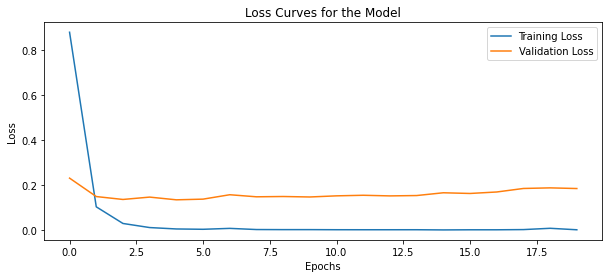

In [164]:
# Plot loss curves

plt.figure(figsize = (10,4))
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for the Model")
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

Let's visualise the accuracy of our model using a **confusion matrix** as follows:

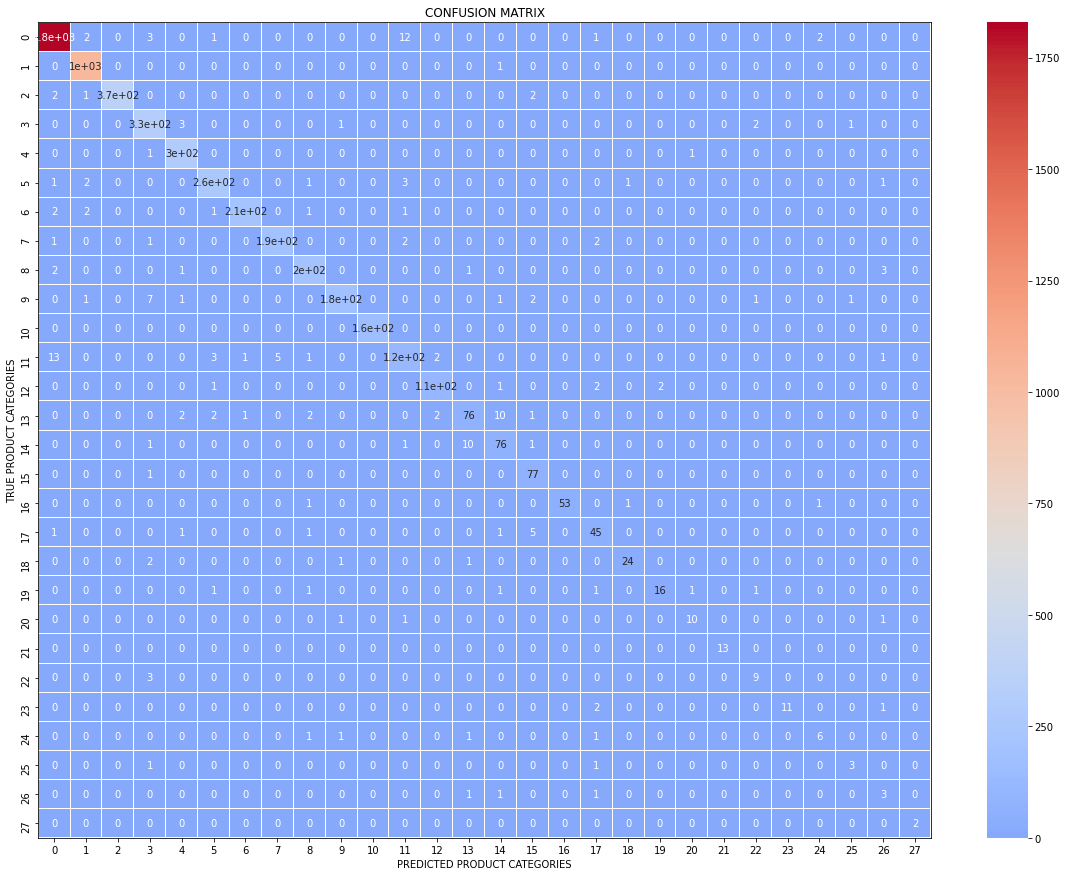

In [177]:
c_matrix = confusion_matrix(y_test, y_hat)

# Converting to dataframe
df_cm = pd.DataFrame(c_matrix)
df_cm.index.name = 'TRUE PRODUCT CATEGORIES'
df_cm.columns.name = 'PREDICTED PRODUCT CATEGORIES'
cm_center = 0.35 * (df_cm.values.max() - df_cm.values.min())

plt.figure(figsize=(20,15))
plt.title("CONFUSION MATRIX")
cm_plot = sns.heatmap(df_cm, annot=True, linewidths=.005, cmap= "coolwarm", center=cm_center)

for _, spine in cm_plot.spines.items():
    spine.set_visible(True)

plt.show()

In [178]:
print(classification_report(y_test, y_hat, target_names=frequent_category_list))

                                  precision    recall  f1-score   support

                        clothing       0.99      0.99      0.99      1850
                       jewellery       0.99      1.00      1.00      1030
                        footwear       1.00      0.99      0.99       372
            mobiles  accessories       0.94      0.98      0.96       335
                      automotive       0.97      0.99      0.98       298
       home decor  festive needs       0.97      0.97      0.97       273
        beauty and personal care       0.99      0.97      0.98       218
                 home furnishing       0.97      0.97      0.97       198
                 kitchen  dining       0.96      0.97      0.96       209
                       computers       0.98      0.93      0.95       194
                         watches       1.00      1.00      1.00       159
                       baby care       0.86      0.82      0.84       147
                 tools  hardware     

***
## Summary of Results

The performance of all the classification approaches used above can be summarised as follows:

| Classification Approach | Accuracy ( % ) |
| :-: | :-: |
| Naive Bayes | ? |
| Logistic Regression | ? |
| Support Vector Machine| ? |
| **Neural Network** | ***?*** |

Clearly, the highest accuracy for predicting product categories is obtained by the ***Neural Network model***.

In [30]:
# Text cleaning pipeline - all functions used above combined together

# Cleaning product description text
def clean_description(text):
    # Remove punctuation marks
    text_clean = remove_punctuation_marks(text)
    
    # Remove stopwords
    text_clean = remove_stopwords(text_clean)
    
    return text_clean
    
    
# Cleaning product category
def clean_category(text):
    # Filter out the primary category from the tree
    text_clean = filter_primary_category(text)
    
    # Remove punctuation marks
    text_clean = remove_punctuation_marks(text_clean)
    
    # Convert to lower case and strip trailing or leading whitespaces
    text_clean = text_clean.lower().strip()
    
    # Remove stopwords
    text_clean = remove_stopwords(text_clean)
    
    return text_clean

    